**Tutorial 6 - Cosmology with Type Ia Supernovae : linear models**

In this tutorial we will experiment with some type Ia supernova data.  This is part of the data used to determine that Universe's expansion is accelerating.

Data obtained is from the Supernova Cosmology Project at:
http://supernova.lbl.gov/union/descriptions.html#Magvsz

Background:

The observed magnitude of an object with luminosity $L$ is

$m = - 2.5 \log\left( \frac{L}{2\pi D_L^2} \right) + m_o = 5 \log\left( D_L \right) + 2.5 \log\left( L \right) + m_o$

where $D_L$ is the luminosity distance.  The peak luminosity of a type Ia supernovae 
is directly related to the width of its lightcurve and its color.  In this data set, the correction to a standard candle has already been done (we will look at this in a later tutorial) and it is reported in terms of the estimated distance modulus

$\mu = 5 \log\left( D_L \right) - 5$

This assumes a Hubble constant and requires a calibration using other distance indicators in local galaxies so there is an additive constant to the distance modulus or a multiplicative constant to the brightness that is not very well constrained, ie the relative brightnesses of the supernovae are well measured but not their absolute brightnesses.

General relativity and the energy content of the Universe predicts $D_L(z)$ or $\mu(z)$ where $z$ is the cosmological redshift of the supernovae.

In this tutorial we will make and test some linear models for $\mu(z)$.  We will also see if a flat Universe without a cosmological constant is an adequate fit to the data.

1) Import the data using the command pandas.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#').

Plot the distance modulus vs redshift with error bars.  Label the axes.

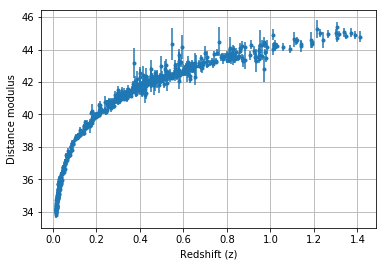

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.stats

data = pd.read_csv("SCPUnion2.1_mu_vs_z.txt",sep='\t',comment='#')

plt.errorbar(data['redshift'], data['dist_mod'], yerr=data['dist_mod_error'], ls='none', marker='.')
plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus')
plt.show()


2) Try fitting this curve with a polynomial models of order 1,2 and 3 using numpy.polyfit(). Use the w parameter to include the errors from the data files in these $\chi^2$ fits.  Plot these models on top of the data.  Leave the errors out to improve clarity.  Do these make good models?

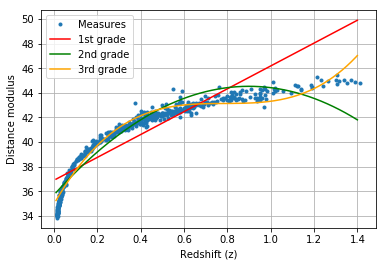

In [6]:
w=1/data['dist_mod_error']

x = np.linspace(0.01, 1.4, 200)

a, b = np.polyfit(data['redshift'], data['dist_mod'], 1, w=w)
y1 = a*x + b

l, m, n = np.polyfit(data['redshift'], data['dist_mod'], 2, w=w)
y2 = l*x*x + m*x +n

p, q, r, s = np.polyfit(data['redshift'], data['dist_mod'], 3, w=w)
y3 = p*x*x*x + q*x*x + r*x + s 

plt.plot(data['redshift'], data['dist_mod'], marker='.', ls='none', label='Measures')
plt.plot(x, y1, c='red', label='1st grade')
plt.plot(x, y2, c='green', label='2nd grade')
plt.plot(x, y3, c='orange', label='3rd grade')

plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus')

plt.legend()
plt.show()

3) Convert the distance modulus into luminosity distance

$D_L = A 10^{\frac{\mu}{5}}$

were we don't know the constant $A$ because of calibration and uncertainties in the Hubble constant.


Fit a second order polynomial to $D_L$ vs $z$.  You can estimate the errors in the distance using the expansion

$ \delta D_L \sim \frac{\ln(10)}{5} ~ D_L \delta \mu$

,the first order expansion of $D_L$ in terms of $\mu$.  This is only an approximation.

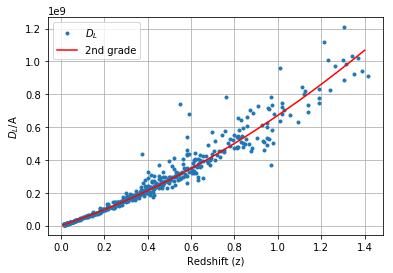

In [7]:
D = 10**(data['dist_mod']/5.)

D_err = (np.log(10)/5)*D*data['dist_mod_error']

we = 1/D_err

l, m, n = np.polyfit(data['redshift'], D, 2, w=we)
y2 = l*x*x + m*x +n

plt.plot(data['redshift'], D, marker='.', ls='none', label=r'$D_{L}$')
plt.plot(x, y2, c='red', label='2nd grade')

plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('$D_{L}$/A')

plt.legend()
plt.show()


4) General relativity and the standard cosmological model predict that to 
second order

$D_L(z) \simeq \frac{c}{H_o} \left[ z + \frac{z^2}{2}(1-q_o) \right]$

where $q_o$ is called the deceleration parameter and is given by

$q_o = \frac{\Omega_m}{2} - \Omega_\Lambda$

where $\Omega_m$ is the density of the Universe in ordinary matter in units of the critical density and $\Omega_\Lambda$ is the energy density of the cosmological constant in the same units.

If the Universe is geometrically flat $\Omega_m+ \Omega_\Lambda = 1$ and 

$q_o = \frac{3}{2}\Omega_m - 1$

If there is no cosmological constant (the expansion is not accelerating) $q_o=1/2$.

This means that in your model $p[0]/p[1] = (1-q_o)/2$

For a flat universe with no cosmological constant $\Omega_m = 1$, $\Omega_\Lambda =0$  $p[0]/p[1] = 1/4$.  

What is your measured value for $q_o$?  If the universe is flat what is your measured value for $\Omega_m$?

In [39]:
q = 1 - 2*l/m
o_m = (2/3.)*(q+1)

print('The measured value of q_0 is:' + format(q, "0.4f"))
print('The measured value of Omega_m is:' + format(o_m, "0.4f"))


The measured value of q_0 is:-0.0274
The measured value of Omega_m is:0.6484


5) This looks good, but the errors are not really on $D_L$.  They are on 
the distance modulus.  We have also not enforced the requirement that $D_L(z=0) =0$. This was not possible with numpy.polyfit() because it will only fit a polynomial and requires that the intercept be free.

What we really want to find is a nonlinear model.  For this lets use scipy.optimize.curve_fit().  For this we must 

a) Define a function func_modulus($z,\mu_o,q_o$) which returns 

$5\log_{10}\left(z + (1-qo)z^2\right) + \mu_o$


In [40]:
def func_modulus(z, muo, qo):
    return (5*np.log10(z+(1-qo)*z*z/2)+muo)

b) Use scipy.optimize.curve_fit() to find the model.  Use the sigma and absolute_sigma=True options to include the errors.

The outputs of this function are model,covariance.

What is the $q_o$ you get in this way?

In [41]:
popt, pcov = scipy.optimize.curve_fit(func_modulus, data['redshift'], data['dist_mod'], sigma=data['dist_mod_error'], absolute_sigma=True)

print(popt)

[43.19682518 -0.1748099 ]


c) Use func_modulus(z,muo,qo) to plot the best fit model over the data.

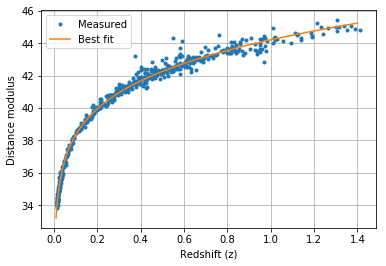

In [42]:
y_best = np.empty(len(x))
for i in range(len(x)):
    y_best[i]= func_modulus(x[i], popt[0], popt[1])

plt.plot(data['redshift'], data['dist_mod'], ls='none', marker='.', label='Measured')
plt.plot(x, y_best, label='Best fit')

plt.grid()
plt.xlabel('Redshift (z)')
plt.ylabel('Distance modulus')

plt.legend()
plt.show()

5) Calculate the $\chi^2$ for this model and data.  Remember that 

$\chi^2 = \sum_i \frac{ \left[ y_i - model(x_i) \right]^2}{\sigma^2} $

Is this an acceptable fit?  Use the $\chi^2$ distribution to find out.  How many degrees of freedom should you use?

In [45]:
y_fit = np.empty(len(data['redshift']))
for j in range(len(data['redshift'])):
    y_fit[j]= func_modulus(data['redshift'][j], popt[0], popt[1])
    
chi = 0.

for t in range(len(data['redshift'])):
    chi = chi + (data['dist_mod'][t]-y_fit[t])*(data['dist_mod'][t]-y_fit[t])

chi = chi/np.var(data['dist_mod'])
chi_rid=chi/float(len(data['redshift'])-2)
print('The value of the reduced chi is: ' + format(chi_rid, "0.4f"))
print('This is an acceptable fit.')

The value of the reduced chi is: 0.0072
This is an acceptable fit.


6) We need to calculate the errors on our measurement of $q_o$.  We will do this in two ways.  

Find the bootstrap variance of your estimate of $q_o$.  This will require you to make a new data sets by sampling from the original one with replacement (Hint: numpy.random.choice(N,N) will give you a random set of integers between 0 and N-1).  Then find $q_o$ from this data set.  Put this in a loop and repeat 1000 times recording the $q_o$ value each time in a vector of $q_o$'s. 

Make a nice histogram of the $q_o$ vector.

This vector of $q_o$'s is approximately sampled from the true distribution.  Find the mean and variance of this vector.  This is a rough estimate of the variance.

What is the measured value of $q_o$ with errors?

Assuming the Universe is flat what is the measured value of $\Omega_m$?

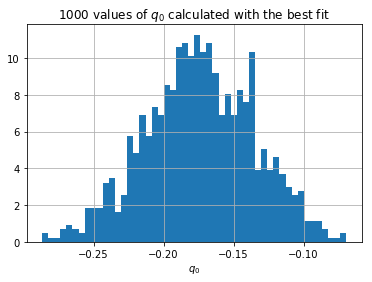

In [46]:
q0_rep = np.empty(1000)
dist_boot = np.empty(len(data['dist_mod']))
red_boot = np.empty(len(data['dist_mod']))
err_boot = np.empty(len(data['dist_mod']))

for y in range(1000):
    boot = np.random.choice(len(data['dist_mod']), len(data['dist_mod']))
    for ii in range(len(data['dist_mod'])):
        dist_boot[ii]=data['dist_mod'][boot[ii]]
        red_boot[ii]=data['redshift'][boot[ii]]
        err_boot[ii]=data['dist_mod_error'][boot[ii]]
    
    popt, pcov = scipy.optimize.curve_fit(func_modulus, red_boot, dist_boot, sigma=err_boot, absolute_sigma=True)
    q0_rep[y] = popt[1]

plt.hist(q0_rep, bins=50, normed=True)
plt.grid()
plt.xlabel(r'$q_0$')
plt.title(r'1000 values of $q_0$ calculated with the best fit')
plt.show()
        

In [48]:
om = (2/3.)*(q0_rep+1)

q0_mean = np.mean(q0_rep)
q0_var = np.std(q0_rep)
om_mean = np.mean(om)
om_var = np.std(om)

print('The value of q0 is: ' + format(q0_mean, "0.4f") + ' with an error of: ' + format(q0_var, "0.4f"))
print('The value of Omega m is: ' + format(om_mean, "0.4f") + ' with an error of: ' + format(om_var, "0.4f"))

The value of q0 is: -0.1741 with an error of: 0.0386
The value of Omega m is: 0.5506 with an error of: 0.0258


**Comment:**  In this tutorial we have made several approximations that might not be justified.  One is that we use an expansion for $D_L$ as a function of $z$ that is not really valid at z ~ 1.  If we use the correct relationship and calculate the errors in a better way we might get a different answer for $\Omega_m$.  We will do this in our next tutorial.

Also another very useful program for doing linear fitting is sklearn.linear_model.LinearRegression().  
It is more prediction oriented, but you might find it useful especially when you have multiple independant and 
dependant variables.
(http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)